# Solving the 1D Diffusion Equation with a Neural Network

In [2]:
import torch
from torch import nn
from torch.autograd.functional import jacobian
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.qmc import LatinHypercube
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors

In [3]:
# Double-precision by default
torch.set_default_dtype(torch.float64)

In [4]:
def derivative(y, x):
    dim = y.shape[-1]
    dydx = torch.zeros_like(y, dtype=y.dtype)
    for i in range(dim):
        yi = y[:,i].sum()
        dydx[:,i] = torch.autograd.grad(yi, x, create_graph=True, allow_unused=True)[0].squeeze()
    return dydx

### 1D Diffusion Equation

In [5]:
# Functions below specify the initial boundary value problem alongside its domain and analytic solution

def u0(x):
    return torch.sin(torch.pi * x)

def dirichlet_bc(x, t):
    return torch.zeros_like(x)

def diffusion_equation(u,x,t):
    u_t = derivative(u, t)
    u_x = derivative(u, x)
    u_xx = derivative(u_x, x)
    
    return u_xx - u_t

def u_analytical(x, t):
    return np.sin(np.pi * x) *np.exp(-(torch.pi)**2 * t)

def spatio_temporal_sample(T, N_st, N_s, N_t):
    sampler = LatinHypercube(1)
    
    #Interior points
    samples_x = torch.tensor(sampler.random(n=N_st))
    samples_t = torch.tensor(T * sampler.random(n=N_st))
    
    # Spatial points at t=0 (initial conditions)
    samples_x_ic = torch.tensor(sampler.random(n=N_t))
    samples_t_ic = torch.zeros((N_t,1))
    
    # Temporal points at x=0,1 (boundary conditions)
    samples_t_bc = torch.tensor(T * sampler.random(n=N_s))
    samples_x_bc = torch.zeros((N_s,1))
    samples_x_bc2 = torch.ones((N_s,1))
    
    return (samples_x, samples_t), (samples_x_ic, samples_t_ic), (samples_x_bc, samples_x_bc2, samples_t_bc)

### Definition of the Feedforward Net

In [6]:
class PiNN(nn.Module):
    def __init__(self, hidden_layers):
        super().__init__()

        prev_nodes_per_layer = 2;
        hidden = []
        for nodes_per_layer in hidden_layers:
            
            # Tanh is required as the PDE is second order in space and ReLU has a vanishing second derivative
            hidden += [nn.Linear(prev_nodes_per_layer, nodes_per_layer), nn.Tanh()]
            prev_nodes_per_layer = nodes_per_layer
        
        self.ff_relu_graph = nn.Sequential(*hidden)
            
        # Output Layer is assumed to be linear
        self.output = nn.Linear(prev_nodes_per_layer, 1)
        
    def forward(self, x, t): 
        return self.output(self.ff_relu_graph(torch.cat((x,t), 1)))

## Proof of Concept

### Generate Test/Train Split

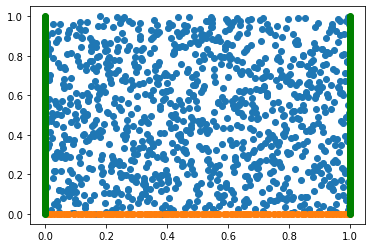

In [7]:
#IBVP parameters
T = 1
N_interior = 2**10
N_bc = 2**9
N_ic = 2**7

# Generate training set
X_train = spatio_temporal_sample(T, N_interior, N_bc, N_ic)
(x_int, t_int), (x_init, t_init), (x_boundary, x_boundary2, t_boundary) = X_train

# Generate test data
X_test = spatio_temporal_sample(T, N_interior, N_bc, N_ic)

plt.scatter(x_int,t_int)
plt.scatter(x_init,t_init)
plt.scatter(x_boundary,t_boundary, c="green")
plt.scatter(x_boundary2, t_boundary, c="green")
plt.show()

### Training of the Network

In [37]:
def train_network_to_ibvp(X_train, pde, ic, bc, hyperparameters=None, verbose=True):
    # Unpack the training data into interior/ic/bc points and set up the minibatch indices
    (x_int, t_int), (x_init, t_init), (x_boundary, x_boundary2, t_boundary) = X_train
        
    # Default Hyperparameters for model and learning
    if hyperparameters is None:
        hidden_layers = [20,20,20]
        batchsize_interior= x_int.shape[0]
        batchsize_boundary= x_boundary.shape[0]
        batchsize_ic = x_init.shape[0]
        number_of_minibatches=1
        epochs = 100
    else:
        for key,val in hyperparameters.items():
            exec(key + '=val')
            
    # Minibatch index set to iterate over
    idx_int = np.array_split(np.arange(x_int.shape[0]), number_of_minibatches)
    idx_init = np.array_split(np.arange(x_init.shape[0]), number_of_minibatches)
    idx_boundary = np.array_split(np.arange(x_boundary.shape[0]), number_of_minibatches)

    # Generate test data
    N_test = 2**10
    (x_test,t_test) = spatio_temporal_sample(T, N_test, 1, 1)[0]
    u_test = u_analytical(x_test, t_test)

    net = PiNN(hidden_layers)
    
    optimizer = torch.optim.LBFGS(net.parameters())
    loss_fn = torch.nn.MSELoss()
    
    if verbose:
        mse_train = []
        mse_test = []
        report_after_e_epochs = min(epochs, 10)
    
        model_parameters = filter(lambda p: p.requires_grad, net.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        print(f'{"Hyperparameters":-^70}')
        print(f'{"Network:":<40}')
        print(net)
        print(f'{"# of model parameters:":<40}{params:>30}\n')
        print(f'{"# of collocation points per batch:":<40}{batchsize_interior:>30}')
        print(f'{"# of boundary points per batch:":<40}{batchsize_boundary:>30}')
        print(f'{"# of initial condition points per batch:":<40}{batchsize_ic:>30}')
        print(f'{"# of minbatches:":<40}{number_of_minibatches:>30}')
        print(f'{"Points per Iteration:":<40}{batchsize_interior * batchsize_boundary * batchsize_ic * number_of_minibatches:>30}')
        print(f'{"Iterations:":<40}{epochs:>30}')
        print(f'{"Total number of collocation points":<40}{epochs * batchsize_interior * batchsize_boundary * batchsize_ic * number_of_minibatches:>30}')
        print(f'{"":-^70}')
        print(f'{"Epoch":^10}|{"Total Loss":^15}|{"Loss (PDE)":^15}|{"Loss (BC)":^15}|{"Loss (IC)":^15}')
        
    for e in range(epochs+1):
        for minibatch in range(number_of_minibatches):

            x = x_int[idx_int[minibatch],:]
            t = t_int[idx_int[minibatch],:]
            
            x_ic = x_init[idx_init[minibatch],:]
            t_ic = t_init[idx_init[minibatch],:]
            
            x_bc_0 = x_boundary[idx_boundary[minibatch],:]
            x_bc_L = x_boundary2[idx_boundary[minibatch],:]
            t_bc = t_boundary[idx_boundary[minibatch],:]
            
            x.requires_grad_(True)
            t.requires_grad_(True)
            
            last_total_loss_in_step = 0
            last_interior_loss_in_step = 0
            last_bc_loss_in_step = 0
            last_ic_loss_in_step = 0
            def compute_loss(x, t, x_ic, t_ic, x_bc_0, x_bc_L, t_bc, optimization=True):
                nonlocal last_total_loss_in_step, last_interior_loss_in_step, last_bc_loss_in_step, last_ic_loss_in_step
                
                if optimization:
                    optimizer.zero_grad()
            
                # Interior
                u = net(x, t)
                mse_interior = loss_fn(pde(u,x,t), torch.zeros_like(u))
            
                # Boundary Condition
                u_bc_0 = net(x_bc_0, t_bc)
                u_bc_L = net(x_bc_L, t_bc)
                mse_boundary = loss_fn(u_bc_0, bc(x_bc_0, t_bc)) + loss_fn(u_bc_L, bc(x_bc_L, t_bc))
        
                # Initial conditions
                u_ic = net(x_ic, t_ic)
                mse_ic = loss_fn(u_ic, ic(x_ic))
        
                #Total Loss
                loss =  mse_interior + mse_boundary + mse_ic
                
                if optimization:
                    loss.backward()
            
                last_total_loss_in_step = loss.item()
                last_interior_loss_in_step = mse_interior.item()
                last_bc_loss_in_step = mse_boundary.item()
                last_ic_loss_in_step = mse_ic.item()
                return loss
            
            optimizer.step(lambda: compute_loss(x, t, 
                                                x_ic, t_ic, 
                                                x_bc_0, x_bc_L, t_bc, 
                                                optimization=True))
            
            if verbose:
                # Monitor training error
                mse_train.append(last_total_loss_in_step)
            
                #Monitor test error (turn autodiff for this)
                with torch.autograd.no_grad():
                    mse_test.append(loss_fn(net(x_test, t_test), u_test))
            
        if verbose and e % report_after_e_epochs == 0:
            print(f'{e:^10}|{last_total_loss_in_step:>15.6e}|{last_interior_loss_in_step:>15.6e}|{last_bc_loss_in_step:>15.6e}|{last_ic_loss_in_step:>15.6e}')
    
    if verbose:
        print(f'{"Iteration limit reached":-^70}')
    if verbose:
        return net, mse_train, mse_test
    return net

## Comparison between PiNN and Analytical Solution

In [38]:
net, mse_train, mse_test = train_network_to_ibvp(X_train, diffusion_equation, u0, dirichlet_bc)

---------------------------Hyperparameters----------------------------
Network:                                
PiNN(
  (ff_relu_graph): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
  )
  (output): Linear(in_features=20, out_features=1, bias=True)
)
# of model parameters:                                             921

# of collocation points per batch:                                1024
# of boundary points per batch:                                    512
# of initial condition points per batch:                           128
# of minbatches:                                                     1
Points per Iteration:                                         67108864
Iterations:                                                        100
Total number of collocation points                        

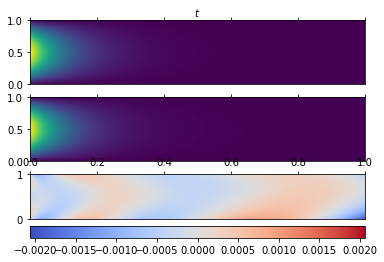

In [20]:
def dstack_product(x, y):
     return np.dstack(np.meshgrid(x, y)).reshape(-1, 2)
    
N_t = 1000
N_x = 900
t = np.linspace(0, T, N_t)
x = np.linspace(0, 1, N_x)
xx, tt = np.meshgrid(x,t)
u_ana = u_analytical(xx,tt)
xt = dstack_product(x,t)

with torch.autograd.no_grad():
    u_net = net(torch.from_numpy(xt[:,0].reshape(-1,1)),torch.from_numpy(xt[:,1]).reshape(-1,1))
u_net = u_net.reshape(N_t, N_x)

fig, ax = plt.subplots(nrows=3, sharex=True)

for a in ax:
    a.xaxis.tick_top()
    a.xaxis.set_label_position('top') 
for tk in ax[0].get_xticklabels():
    tk.set_visible(True)
for tk in ax[-1].get_xticklabels():
    tk.set_visible(True)
    
ax[0].pcolormesh(tt,xx,u_ana)
ax[1].pcolormesh(tt,xx,u_net)
im = ax[2].pcolormesh(tt, xx, u_net-u_ana,
                      cmap="coolwarm",
                      norm=colors.CenteredNorm())

divider = make_axes_locatable(ax[2])
cax = divider.new_vertical(size="25%", pad=0.1, pack_start=True)
fig.add_axes(cax)
cax.set_xlabel(r"$u_\text{analytical} - u_{net}$")
fig.colorbar(im, cax=cax, orientation="horizontal")

ax[0].set_xlabel(r"$t$")
plt.show()

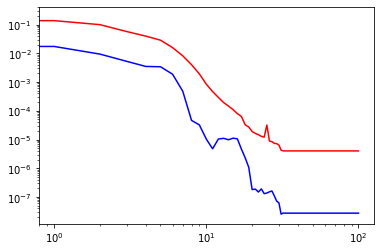

In [106]:
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
epoch = np.arange(epochs+1)
ax.plot(epoch, mse_train, color="red")
ax.plot(epoch, mse_test, color="blue")
plt.show()